In [1]:
import sys
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('/used_cars.csv') 

In [6]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [7]:
age = df['model_year'].max() - df['model_year']
age.head()

0    11
1     3
2     2
3     9
4     3
Name: model_year, dtype: int64

In [8]:
df['milage'].head()

0    51,000 mi.
1    34,742 mi.
2    22,372 mi.
3    88,900 mi.
4     9,835 mi.
Name: milage, dtype: object

In [13]:
milage = df['milage']
milage = milage.str.replace(",", "")
milage = milage.str.replace("mi.", "")
milage = milage.astype(int)
milage.head()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_3992/1474472867.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  milage = milage.str.replace("mi.", "")


0    51000
1    34742
2    22372
3    88900
4     9835
Name: milage, dtype: int32

In [14]:
print(milage.apply(type).unique())

[<class 'int'>]


In [15]:
df['price'].head()

0    $10,300
1    $38,005
2    $54,598
3    $15,500
4    $34,999
Name: price, dtype: object

In [16]:
price = df['price']
price = price.str.replace(",", "")
price = price.str.replace("$", "")
price = price.astype(int)
price.head()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_3992/272676927.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace("$", "")


0    10300
1    38005
2    54598
3    15500
4    34999
Name: price, dtype: int32

In [17]:
print(price.apply(type).unique())

[<class 'int'>]


In [18]:
# accident is categorical variable
df['accident'].value_counts()

None reported                             2910
At least 1 accident or damage reported     986
Name: accident, dtype: int64

In [19]:
accident_free = df['accident'] == 'None reported'
accident_free = accident_free.astype(int)

In [20]:
# Preparation training data X
X = torch.column_stack([
    torch.tensor(age.values, dtype = torch.float32),
    torch.tensor(milage.values, dtype = torch.float32),
    torch.tensor(accident_free.values, dtype = torch.float32)
])
X

tensor([[1.1000e+01, 5.1000e+04, 0.0000e+00],
        [3.0000e+00, 3.4742e+04, 0.0000e+00],
        [2.0000e+00, 2.2372e+04, 1.0000e+00],
        ...,
        [2.0000e+00, 2.1160e+03, 1.0000e+00],
        [4.0000e+00, 3.3000e+04, 1.0000e+00],
        [4.0000e+00, 4.3000e+04, 0.0000e+00]])

In [21]:
print(f"age type: {type(age)}, age shape: {age.shape if hasattr(age, 'shape') else 'no shape'}")
print(f"milage type: {type(milage)}, milage shape: {milage.shape if hasattr(milage, 'shape') else 'no shape'}")
print(f"accident free type: {type(accident_free)}, accident free shape: {accident_free.shape if hasattr(accident_free, 'shape') else 'no shape'}")

age type: <class 'pandas.core.series.Series'>, age shape: (4009,)
milage type: <class 'pandas.core.series.Series'>, milage shape: (4009,)
accident free type: <class 'pandas.core.series.Series'>, accident free shape: (4009,)


In [22]:
#print(age.apply(type).unique())
#print(milage.apply(type).unique())
#print(accident_free.apply(type).unique())

In [23]:
x_mean = X.mean(axis = 0)
x_std = X.std(axis = 0)
X = (X - x_mean) / x_std
print(x_mean)
print(x_std)

tensor([8.4844e+00, 6.4718e+04, 7.2587e-01])
tensor([6.1048e+00, 5.2297e+04, 4.4613e-01])


In [24]:
# preparation of y data
y = torch.tensor(price, dtype = torch.float32).reshape(-1, 1)

In [25]:
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [26]:
#model building
model = nn.Linear(3,1)  #2 = number of independent variables and 1 = number of dependent variable
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [27]:
losses = []
for i in range(0, 3000):
    
    #Training Pass
    optimizer.zero_grad()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(loss.item())
    losses.append(loss.item())

1.3385069370269775
1.1673721075057983
1.079292893409729
1.0265566110610962
0.9920002222061157
0.9681969881057739
0.951335608959198
0.9391945004463196
0.9303638339042664
0.9239009618759155
0.9191516637802124
0.9156526327133179
0.913070023059845
0.9111620783805847
0.9097515344619751


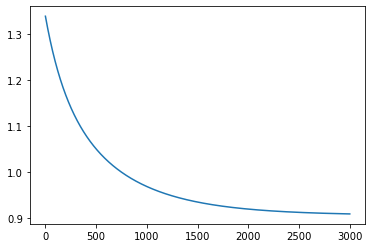

In [28]:
plt.plot(losses)

In [29]:
# do prediction on new data
x_new = torch.tensor([
    [5, 10000, 1],
    [5, 10000, 0]
], dtype = torch.float32)

In [30]:
prediction = model((x_new - x_mean) / x_std)
print(prediction)
print(prediction * y_std + y_mean)

tensor([[0.2998],
        [0.2283]], grad_fn=<AddmmBackward0>)
tensor([[68149.9219],
        [62526.2383]], grad_fn=<AddBackward0>)
